In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'
import numpy as np
# Import custom code
from erpsc.count_hack import Count
from erpsc.core.io import save_pickle_obj, load_pickle_obj
import csv
import scipy.cluster.hierarchy as hier
import re
from sklearn import manifold

In [339]:
def load_dataPM(terms_file, pairs_file):    
    terms = []
    with open(terms_file, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            terms.append(row[1])

    # load co-count matrix from file
    co_count = np.genfromtxt(pairs_file, delimiter=',')
    # fill the lower half of the matrix
    count = co_count + co_count.T - np.diag(co_count.diagonal())
    
    return terms, count

def load_dataCS(terms_file, pairs_file):    
    terms = []
    with open(terms_file, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            terms.append(row[0])

    # load co-count matrix from file
    count = np.genfromtxt(pairs_file, delimiter=',')
    
    #gotta prune
    return terms, count

def jacard_dist(co_counts):
    # get jacardi index
    D = np.shape(co_counts)[0]
    X = co_counts
    jacardD = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            if X[i,j] != 0.:            
                jacardD[i,j] = X[i,j]/(X[i,i]+X[j,j]-X[i,j])

    return jacardD

def top_N(terms, co_counts, N=10):
    counts = np.diag(co_counts)
    ranked = np.argsort(counts)[::-1]
    top_terms = []
    for idx in ranked[:N]:
        top_terms.append((terms[idx],counts[idx]))
        
    return top_terms

def norm_co_count(co_count):
    normed = np.zeros(np.shape(co_count))
    for idx in range(np.shape(normed)[0]):
        normed[idx,:] = co_count[idx,:]/co_count[idx,idx]
        
    return normed

### top-terms search

In [174]:
terms, co_counts = load_dataPM('./data_pubmed/terms_thr_neuro.csv','./data_pubmed/paircount_PMneuro.csv')
ttPMN = top_N(terms,co_counts/244972.,25)
terms, co_counts = load_dataPM('./data_pubmed/terms_thr_cog.csv','./data_pubmed/paircount_PMcog.csv')
ttPMC = top_N(terms,co_counts/365464.,25)
terms, co_counts = load_dataCS('data_pubmed/term_count_single.csv', './data_CS/pairs_all.csv')
ttCS = top_N(terms,co_counts/5471.,25)

with open('topterms.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for idx, t in enumerate(ttPMN):
        spamwriter.writerow([ttCS[idx][0],ttCS[idx][1], ttPMC[idx][0],ttPMC[idx][1], t[0], t[1]])        

138


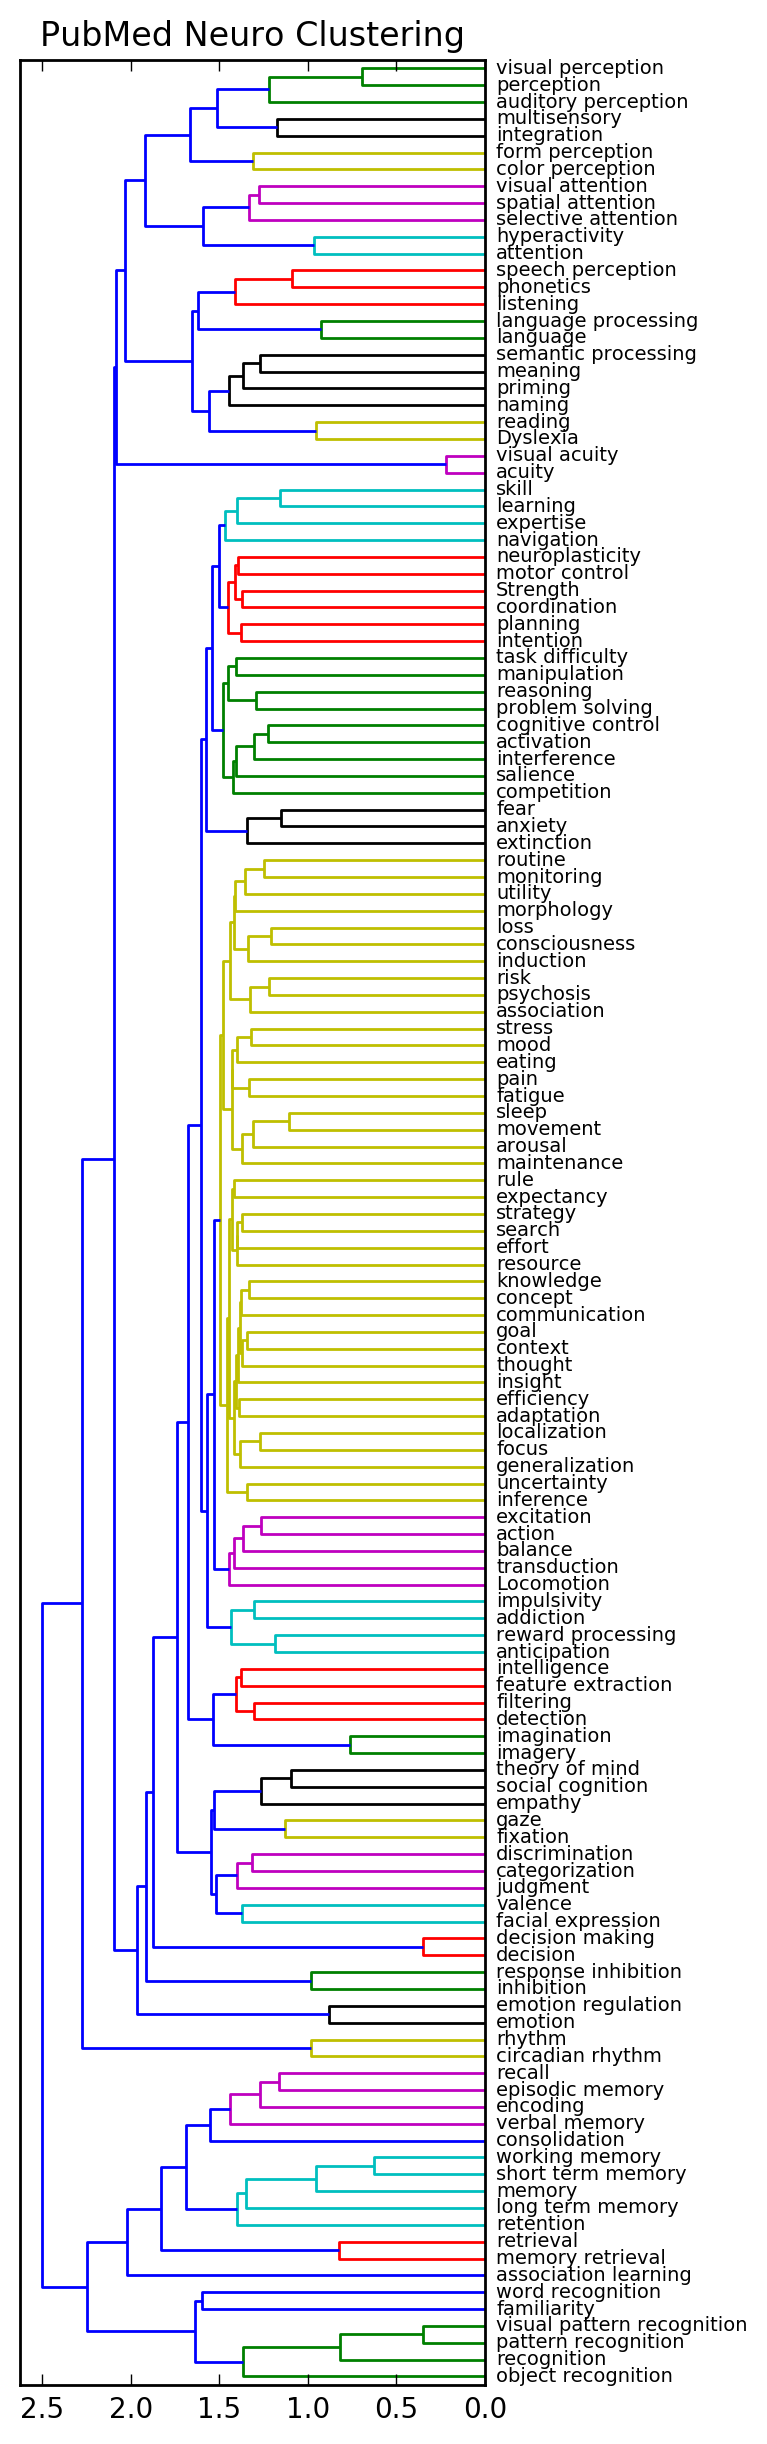

In [347]:
terms, co_counts = load_dataPM('./data_pubmed/terms_thr_neuro.csv','./data_pubmed/paircount_PMneuro.csv')
#terms, co_counts = load_dataPM('./data_pubmed/terms_thr_cog.csv','./data_pubmed/paircount_PMcog.csv')
print len(terms)
JD = jacard_dist(co_counts/244972.)
Y = hier.linkage(norm_co_count(co_counts),method='complete')
plt.figure(figsize=(3,15))
Z = hier.dendrogram(Y,orientation='left',labels=terms, color_threshold=1.495, leaf_font_size=7)

JD_re = JD[Z['leaves'],:]
JD_re = JD_re[:,Z['leaves']]
plt.title('PubMed Neuro Clustering')

1.4946435317


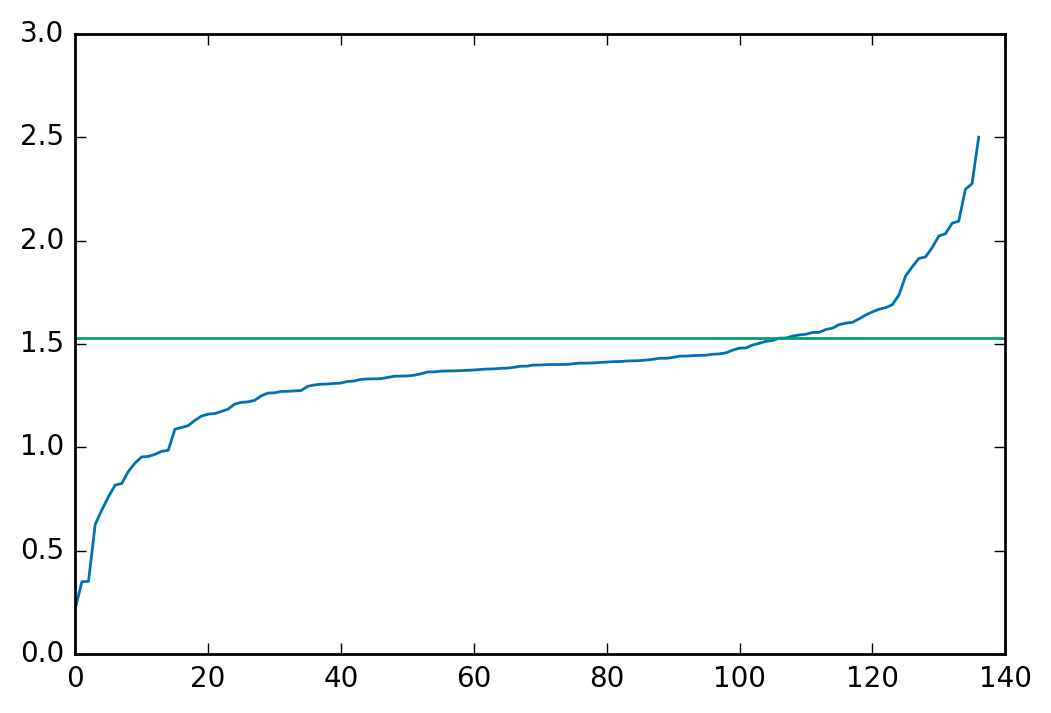

In [348]:
cluster_vals = np.sort([Z['dcoord'][idx][1] for idx in range(len(Z['dcoord']))])
print cluster_vals[-35]
plt.plot(cluster_vals)
plt.plot([0., 140.],2*[cluster_vals[-30]])

In [349]:
[terms[idx] for idx in np.argsort(co_counts[terms.index('consciousness')])[::-1]]

['consciousness',
 'loss',
 'monitoring',
 'sleep',
 'perception',
 'attention',
 'memory',
 'activation',
 'movement',
 'risk',
 'rhythm',
 'arousal',
 'induction',
 'pain',
 'detection',
 'association',
 'action',
 'visual perception',
 'recognition',
 'knowledge',
 'thought',
 'integration',
 'focus',
 'communication',
 'concept',
 'context',
 'routine',
 'stress',
 'learning',
 'decision',
 'inhibition',
 'recall',
 'maintenance',
 'language',
 'localization',
 'emotion',
 'anxiety',
 'goal',
 'decision making',
 'utility',
 'psychosis',
 'imagery',
 'discrimination',
 'pattern recognition',
 'auditory perception',
 'search',
 'Strength',
 'fear',
 'strategy',
 'working memory',
 'visual pattern recognition',
 'insight',
 'adaptation',
 'rule',
 'mood',
 'reading',
 'efficiency',
 'intelligence',
 'priming',
 'circadian rhythm',
 'balance',
 'intention',
 'gaze',
 'fixation',
 'retrieval',
 'imagination',
 'encoding',
 'interference',
 'generalization',
 'manipulation',
 'listening

86


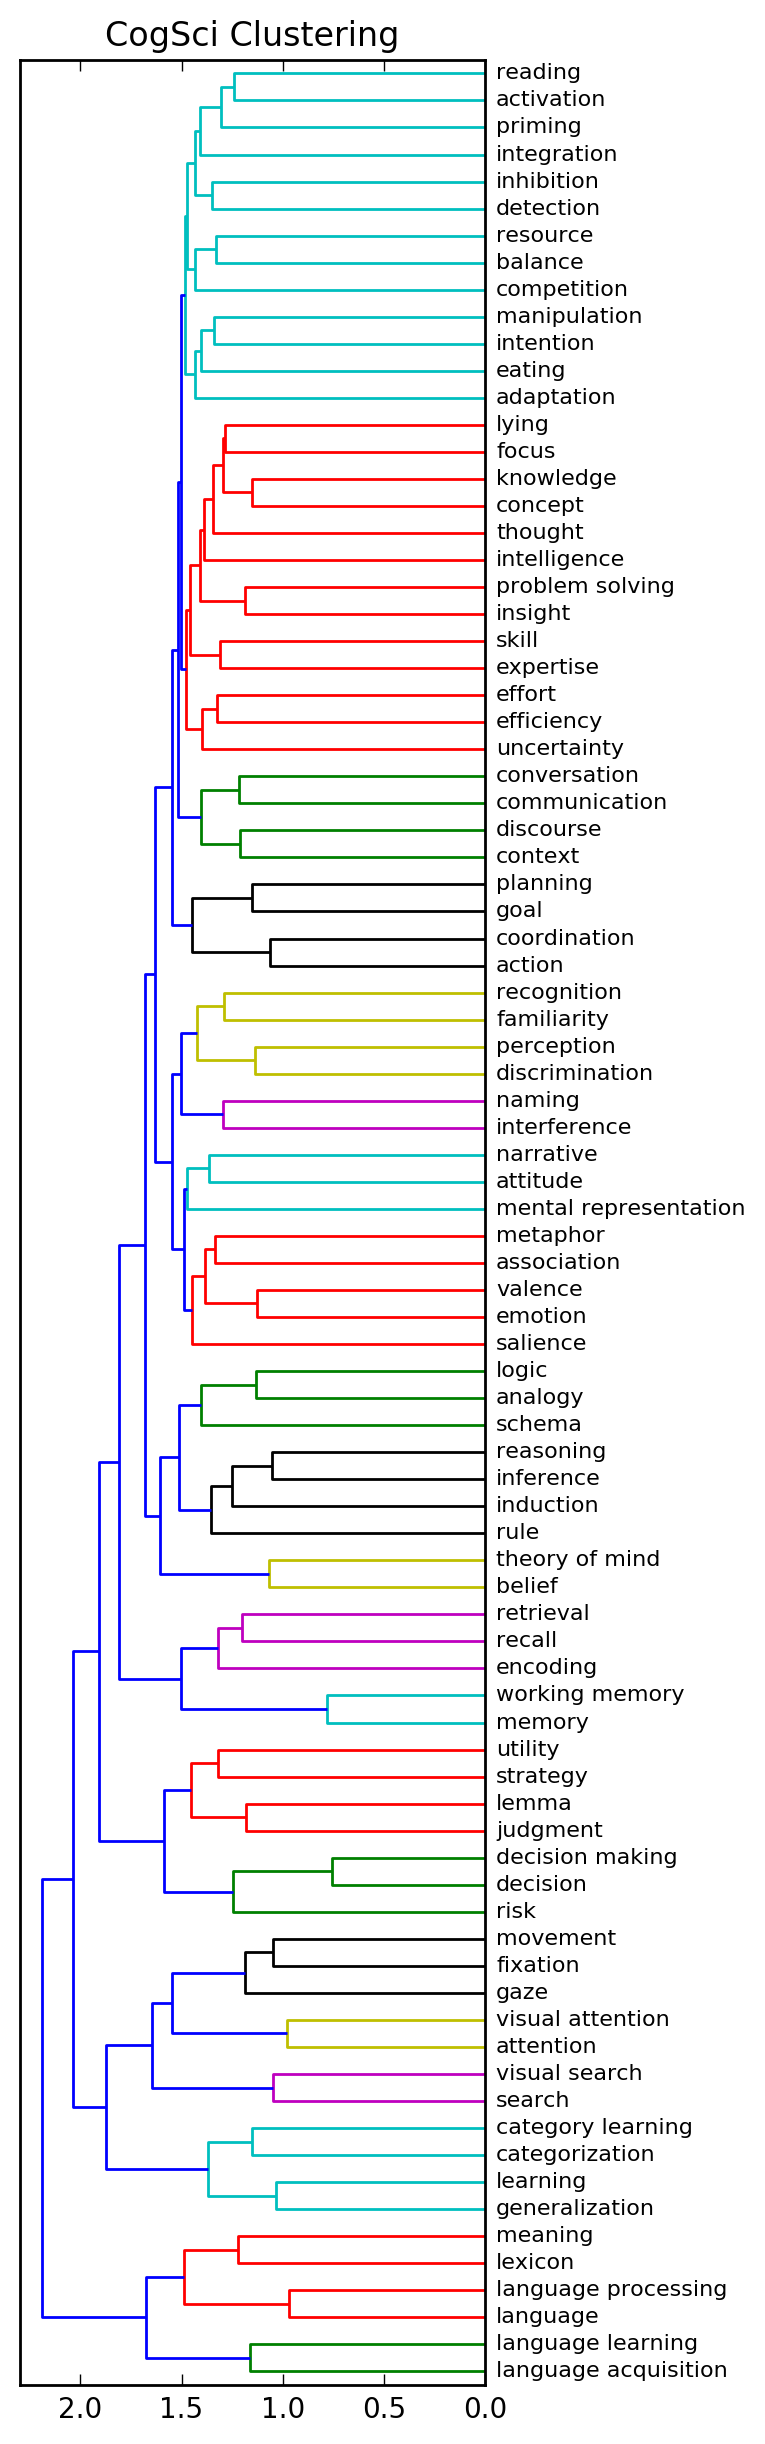

In [352]:
terms, co_counts = load_dataCS('data_pubmed/term_count_single.csv', './data_CS/pairs_all.csv')
sig_terms = np.where(np.diag(co_counts)>50)[0]
terms = [terms[idx] for idx in sig_terms]
co_counts = co_counts[sig_terms,:]
co_counts = co_counts[:,sig_terms]
print(len(sig_terms))

JD = jacard_dist(co_counts/5471)
Y = hier.linkage(norm_co_count(co_counts),method='complete')
plt.figure(figsize=(3,15))
Z = hier.dendrogram(Y,orientation='left',labels=terms, color_threshold=1.4896, leaf_font_size=8)

JD_re = JD[Z['leaves'],:]
JD_re = JD_re[:,Z['leaves']]
plt.title('CogSci Clustering')

1.48963064381


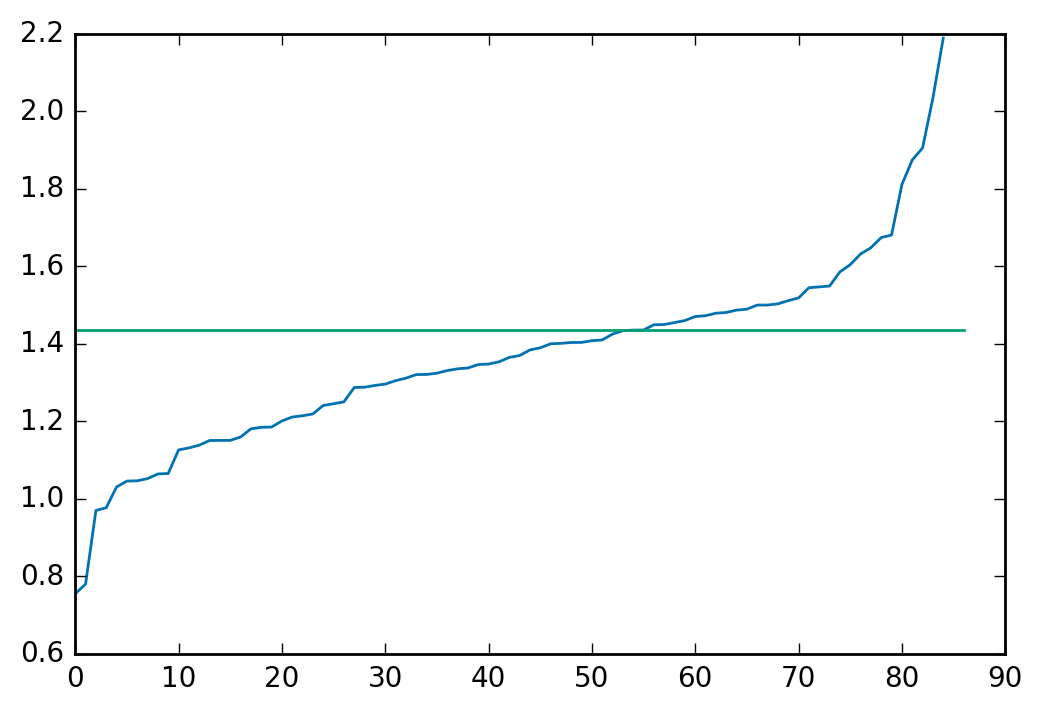

In [351]:
cluster_vals = np.sort([Z['dcoord'][idx][1] for idx in range(len(Z['dcoord']))])
print cluster_vals[-20]
plt.plot(cluster_vals)
plt.plot([0., len(terms)],2*[cluster_vals[-30]])

In [344]:
mds = manifold.MDS(n_components=2, max_iter=3000, dissimilarity='precomputed')
pos = mds.fit(co_counts).embedding_

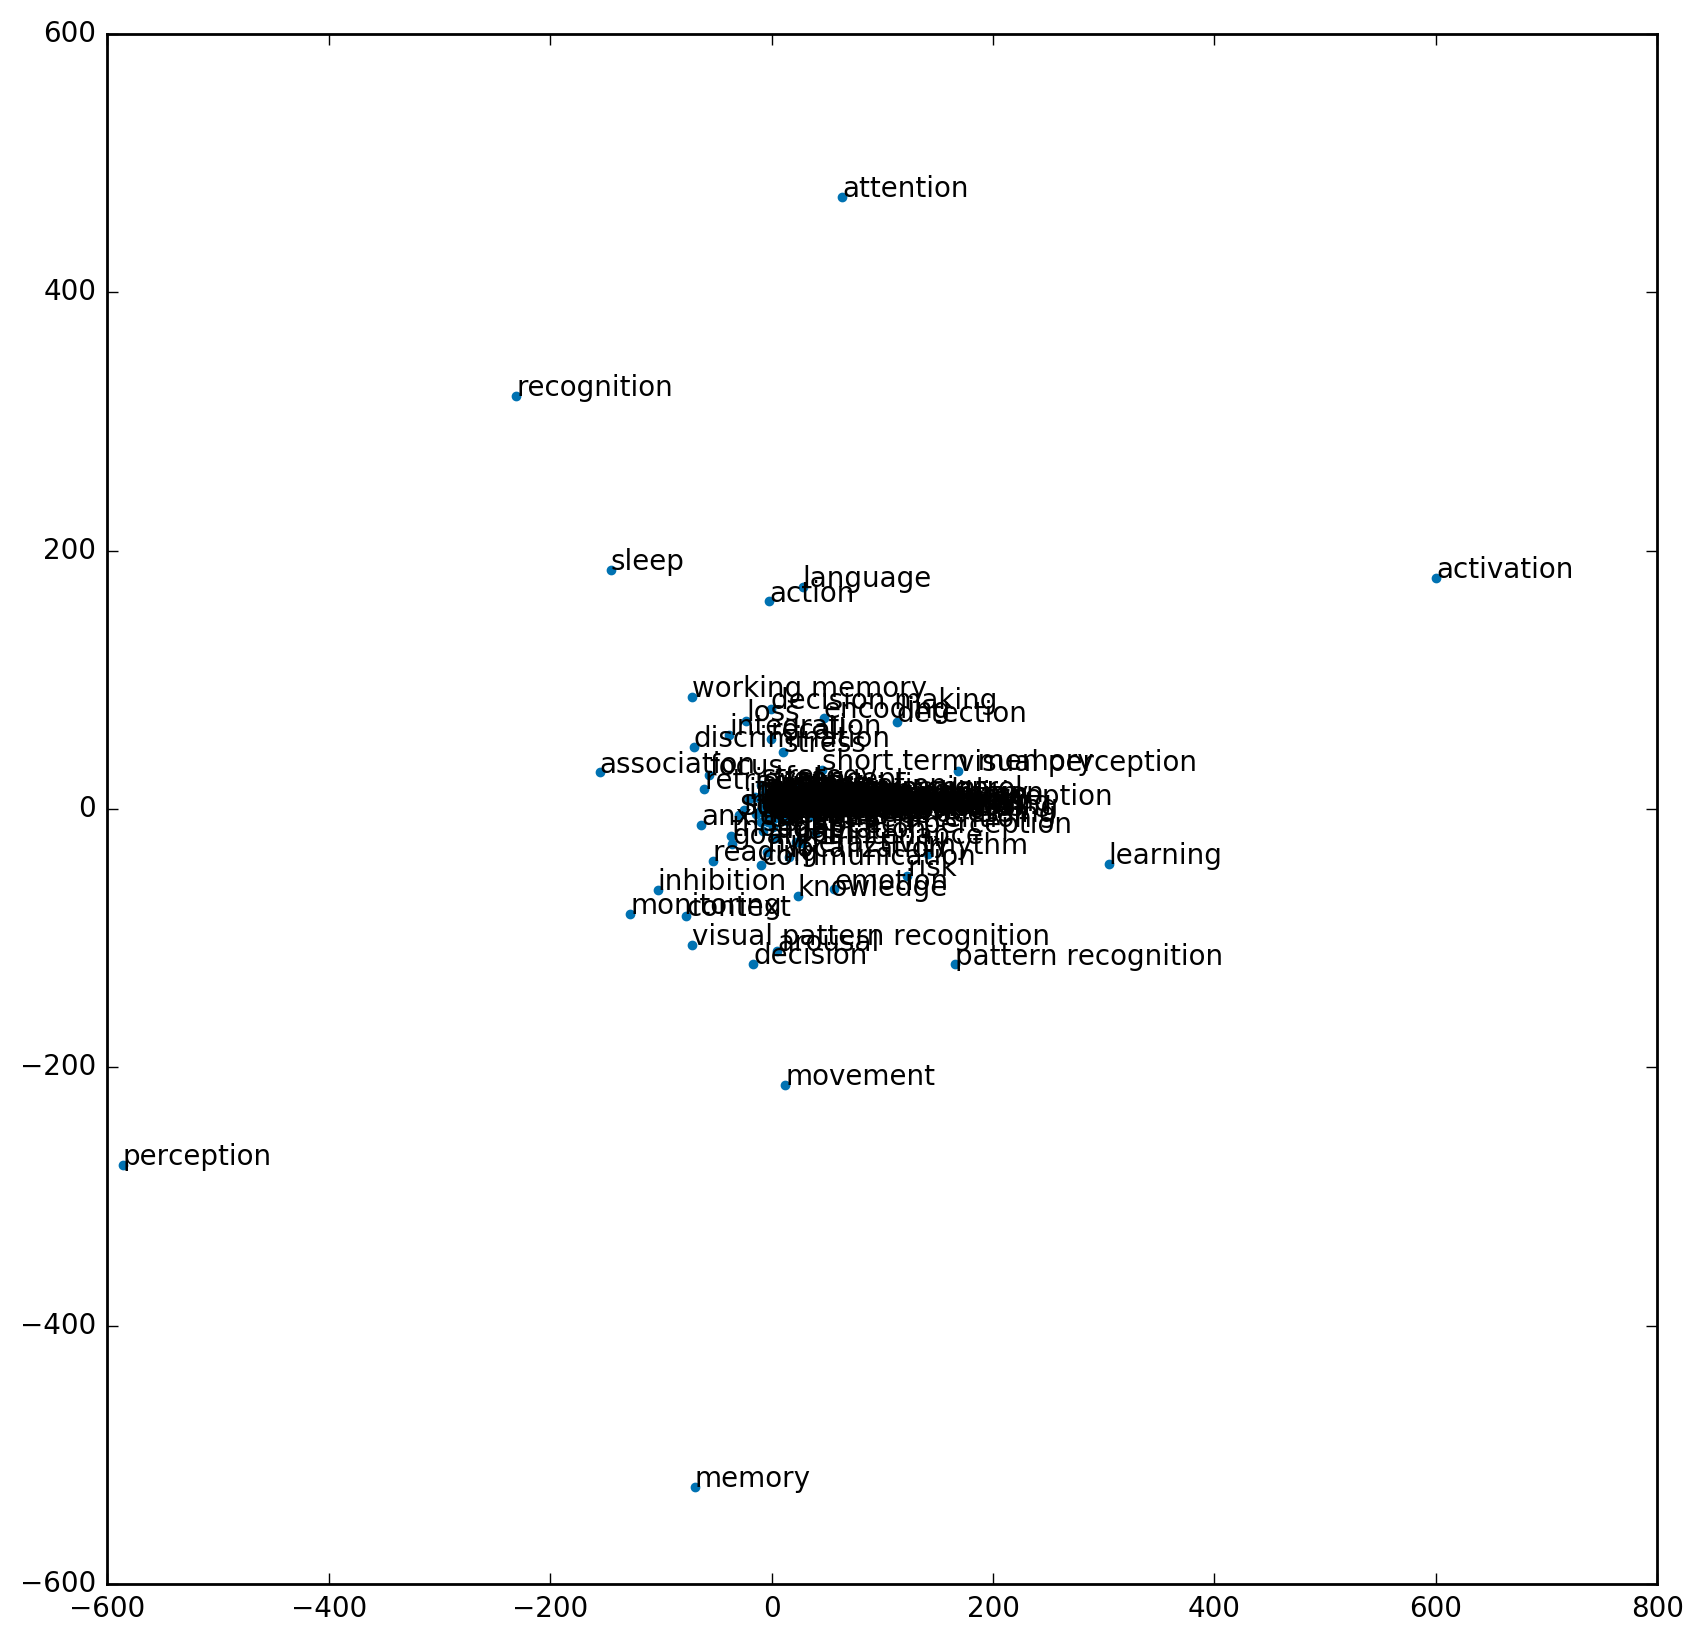

In [345]:
plt.figure(figsize=(10,10))
plt.plot(pos[:,0], pos[:,1], '.')
for idx, t in enumerate(terms):
    plt.text(pos[idx,0],pos[idx,1],t)

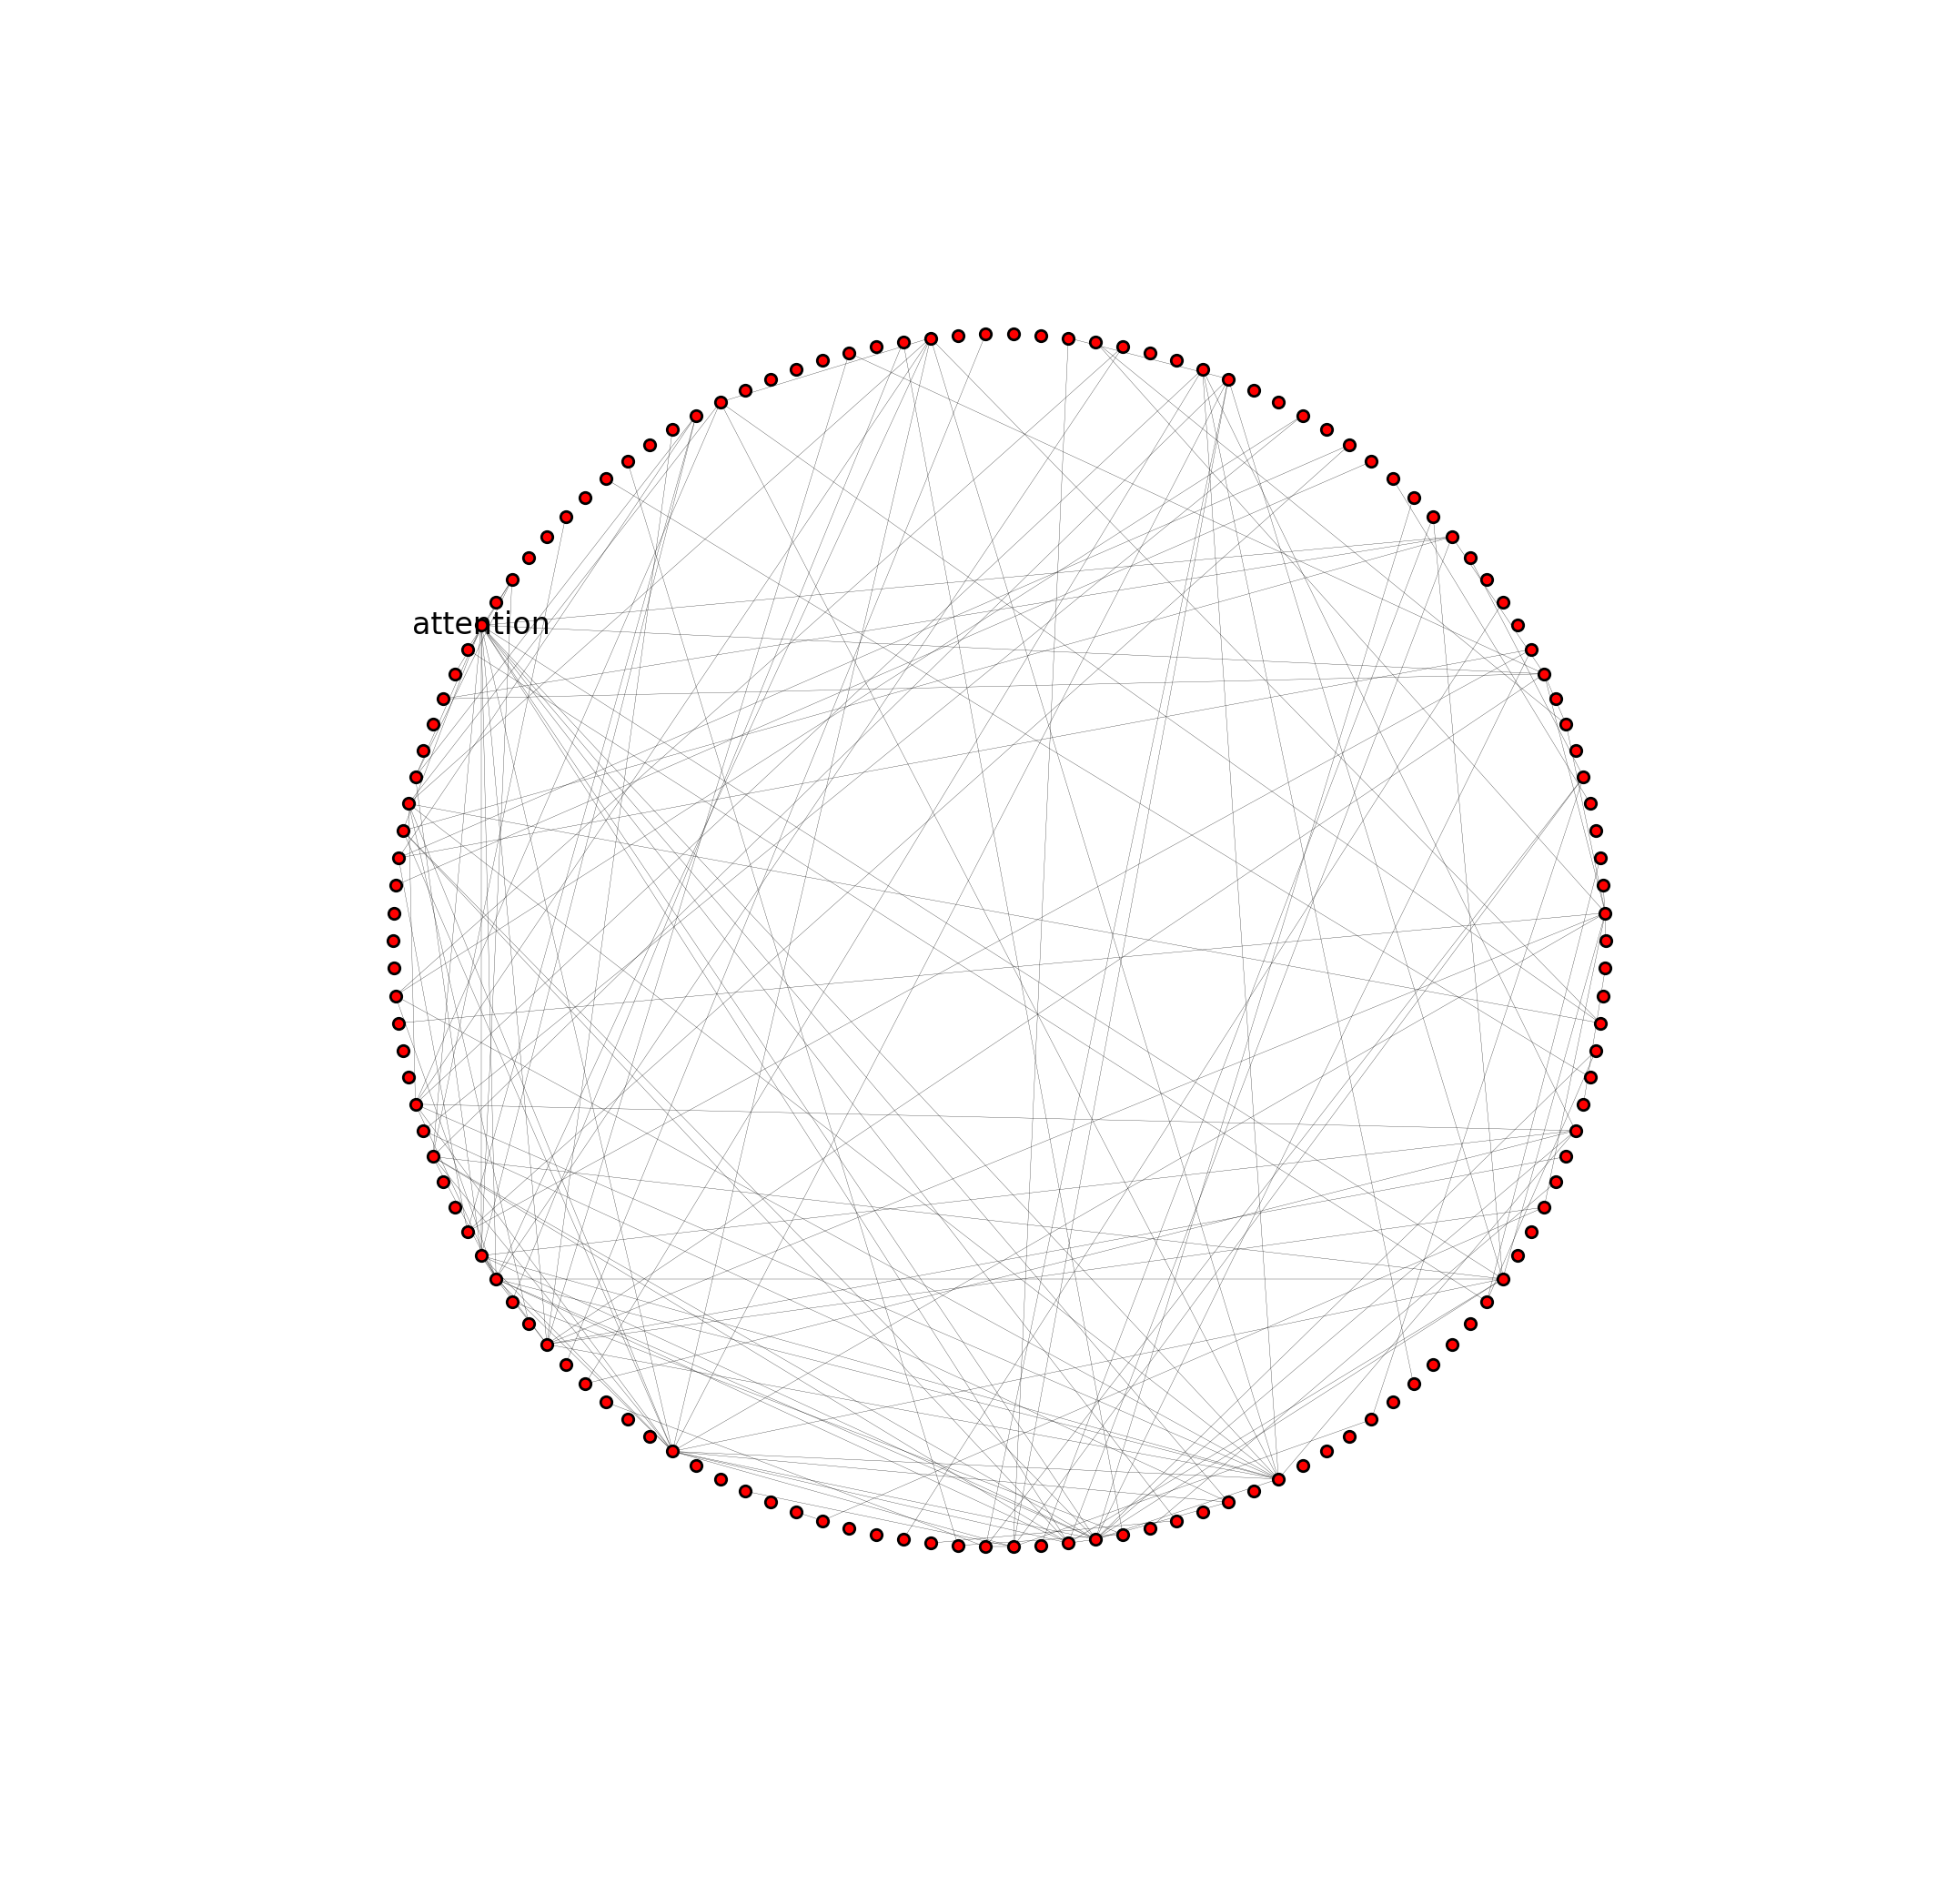

In [263]:
import networkx as nx
G = nx.Graph()
#G.add_nodes_from(range(len(terms)))
for x in range(len(terms)):
    for y in range(len(terms)):
        if JD_re[x,y]>0.05:
            G.add_edge(terms[x],terms[y])

plt.figure(figsize=(10,10))            
nx.draw_circular(G, node_size=20, width=0.1, labels={'attention':'attention'})
#nx.draw_networkx_labels(G, labels={'0':'0'})
#nx.draw_networkx_labels(G, labels=terms, font_size=10)
#nx.path_graph(4)
#pos=nx.circular_layout(G)
